In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
from typing import List, Dict, Any
from sklearn.tree import plot_tree

In [446]:
# Global variable to store LabelEncoders
global le_dict
le_dict = {}

In [447]:
# Step 1: Load Datasets
academic_records = pd.read_csv("student_academic_records.csv")
demographic_data = pd.read_csv("student_demographic_data.csv")
enrollmet_data = pd.read_csv('student_enrollment_data.csv')

In [448]:
print("Enrollment Data Columns:", enrollment_data.columns)
print("Academic Records Columns:", academic_records.columns)
print("Demographic Data Columns:", demographic_data.columns)


Enrollment Data Columns: Index(['Full Name', 'Gender', 'Enrollment Status', 'Program of Study',
       'Enrollment Date', 'Graduation Date', 'County', 'University Enrolled'],
      dtype='object')
Academic Records Columns: Index(['Full Name', 'ID No', 'Gender', 'Enrollment Date', 'Program of Study',
       'Course Code', 'Semester', 'Grade', 'GPA', 'Cumulative GPA',
       'Course Status', 'Academic Standing'],
      dtype='object')
Demographic Data Columns: Index(['Full Name', 'ID No', 'Gender', 'Date of Birth', 'Age', 'Ethnicity',
       'Disability Status', 'Household Income', 'Primary Language', 'Grade',
       'County', 'School Type'],
      dtype='object')


In [449]:
print(enrollment_data.isnull().sum())
print(academic_records.isnull().sum())
print(demographic_data.isnull().sum())

Full Name                 0
Gender                    0
Enrollment Status         0
Program of Study          0
Enrollment Date           0
Graduation Date        2540
County                    0
University Enrolled       0
dtype: int64
Full Name            0
ID No                0
Gender               0
Enrollment Date      0
Program of Study     0
Course Code          0
Semester             0
Grade                0
GPA                  0
Cumulative GPA       0
Course Status        0
Academic Standing    0
dtype: int64
Full Name               0
ID No                   0
Gender                  0
Date of Birth           0
Age                     0
Ethnicity               0
Disability Status    1051
Household Income        0
Primary Language        0
Grade                   0
County                  0
School Type             0
dtype: int64


In [450]:
#Standardize Column Names to ensure that the column names are consistent across all dataframes.  rename Program of Study / Major to Program of Study
enrollment_data.rename(columns={"Program of Study / Major": "Program of Study"}, inplace=True)


In [451]:
# Merge on columns that exist in both datasets
common_columns = list(set(enrollment_data.columns) & set(academic_records.columns))
merged_data = pd.merge(enrollment_data, academic_records, on=common_columns, how='outer')

common_columns = list(set(merged_data.columns) & set(demographic_data.columns))
merged_data = pd.merge(merged_data, demographic_data, on=common_columns, how='outer')

In [452]:
# Remove personally identifiable information (PII)
merged_data = merged_data.drop(['Full Name', 'ID No'], axis=1)

In [453]:
# Feature selection
features = ['Gender', 'Program of Study', 'GPA', 'Cumulative GPA', 'Academic Standing',
            'Age', 'Ethnicity', 'Household Income', 'Primary Language', 'School Type']
target = 'Enrollment Status'

In [454]:
# Prepare the data
X = merged_data[features]
y = merged_data[target]

In [455]:
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [456]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
le_dict = {}
for column in X.select_dtypes(include=['object']):
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))
    le_dict[column] = le

In [457]:
# Handle NaN values in the target variable
y = y.fillna(y.mode()[0])  # Fill NaN with the most frequent value

In [458]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [459]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [460]:
# Save the model and label encoders
joblib.dump(rf_model, 'random_forest_model.joblib')
joblib.dump(le_dict, 'label_encoders.joblib')

['label_encoders.joblib']

In [461]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [462]:
# Evaluate the model
print("Model Performance:")
print(classification_report(y_test, y_pred))

Model Performance:
              precision    recall  f1-score   support

    Enrolled       0.89      0.92      0.90      2359
   Graduated       0.30      0.26      0.28       319
   Withdrawn       0.32      0.31      0.31       322

    accuracy                           0.78      3000
   macro avg       0.51      0.49      0.50      3000
weighted avg       0.77      0.78      0.77      3000



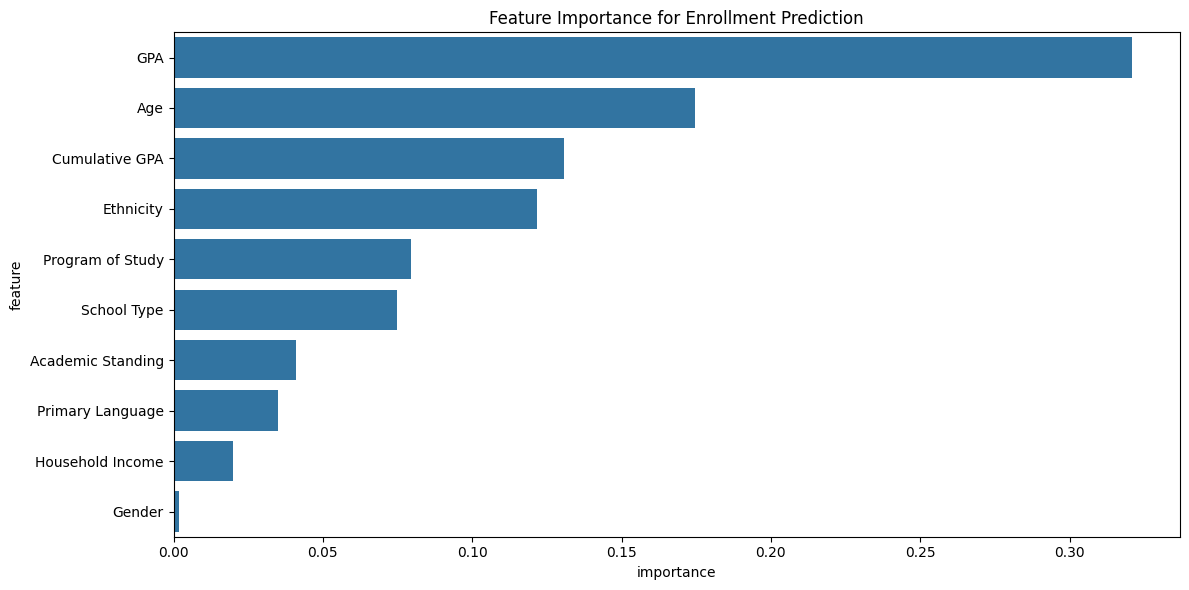

In [463]:
# Visualize feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Enrollment Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [464]:
# Load the model and label encoders
rf_model = joblib.load('random_forest_model.joblib')
le_dict = joblib.load('label_encoders.joblib')

In [465]:
def needs_support(student_data):
    global le_dict, rf_model
    # Create a copy of the input data
    encoded_data = student_data.copy()

    # Encode categorical variables and convert numerical variables
    for column in rf_model.feature_names_in_:
        if column in le_dict:
            # Categorical variable
            encoded_data[column] = le_dict[column].transform(encoded_data[column].astype(str))
        else:
            # Numerical variable
            encoded_data[column] = encoded_data[column].astype(float)

    # Ensure all required features are present and in the correct order
    features = rf_model.feature_names_in_
    encoded_data = encoded_data[features]

    prediction = rf_model.predict_proba(encoded_data)
    return prediction[0][1] > 0.5

In [466]:
# Example of using the model for a new student
new_student = pd.DataFrame({
    'Gender': ['Male'],
    'Program of Study': ['Computer Science'],
    'GPA': [3.2],
    'Cumulative GPA': [3.1],
    'Academic Standing': ['Good'],
    'Age': [20],
    'Ethnicity': ['Caucasian'],
    'Household Income': [50000],
    'Primary Language': ['English'],
    'School Type': ['Public']
})


In [467]:
def plot_feature_importance(model, features):
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    sns.barplot(x='importance', y='feature', data=feature_importance, hue='feature', legend=False, palette='viridis')
    plt.title('Feature Importance', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

In [489]:
def plot_enrollment_status_distribution(y):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y, palette='Set2')
    plt.title('Enrollment Status Distribution', fontsize=16)
    plt.xlabel('Enrollment Status', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    plt.savefig('enrollment_status_distribution.png')
    plt.show()

In [483]:
def plot_gpa_vs_enrollment_status(X, y):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=X['GPA'], hue=y, legend=False, palette='coolwarm')
    plt.title('GPA vs. Enrollment Status', fontsize=16)
    plt.xlabel('Enrollment Status', fontsize=12)
    plt.ylabel('GPA', fontsize=12)
    plt.tight_layout()

    plt.show()



In [484]:
def plot_enrollment_status_distribution(y):
    plt.figure(figsize=(8, 6))
    unique_values = y.unique()
    sns.countplot(x=y, order=unique_values)
    plt.title('Enrollment Status Distribution', fontsize=16)
    plt.xlabel('Enrollment Status', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Manually set colors
    colors = sns.color_palette("Set2", n_colors=len(unique_values))
    for i, patch in enumerate(plt.gca().patches):
        patch.set_facecolor(colors[i % len(colors)])

    plt.tight_layout()
    plt.show()

In [486]:
def plot_decision_tree(model, features, max_depth=3):
    plt.figure(figsize=(20, 10))
    tree = model.estimators_[0]  # Get the first tree from the random forest
    plot_tree(tree,
              feature_names=features,
              class_names=model.classes_,
              filled=True,
              rounded=True,
              max_depth=max_depth,
              fontsize=10)
    plt.title(f'Decision Tree (Max Depth: {max_depth})', fontsize=16)
    plt.tight_layout()
    plt.show()



In [487]:
def plot_feature_correlations(X):
    plt.figure(figsize=(12, 10))
    correlation_matrix = X.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlations', fontsize=16)
    plt.tight_layout()
    plt.show()

In [490]:
# Function to create all visualizations
def create_visualizations(model, X, y, features):
    plot_feature_importance(model, features)
    plot_enrollment_status_distribution(y)
    plot_gpa_vs_enrollment_status(X, y)
    plot_age_vs_enrollment_status(X, y)
    plot_decision_tree(model, features)
    plot_feature_correlations(X)

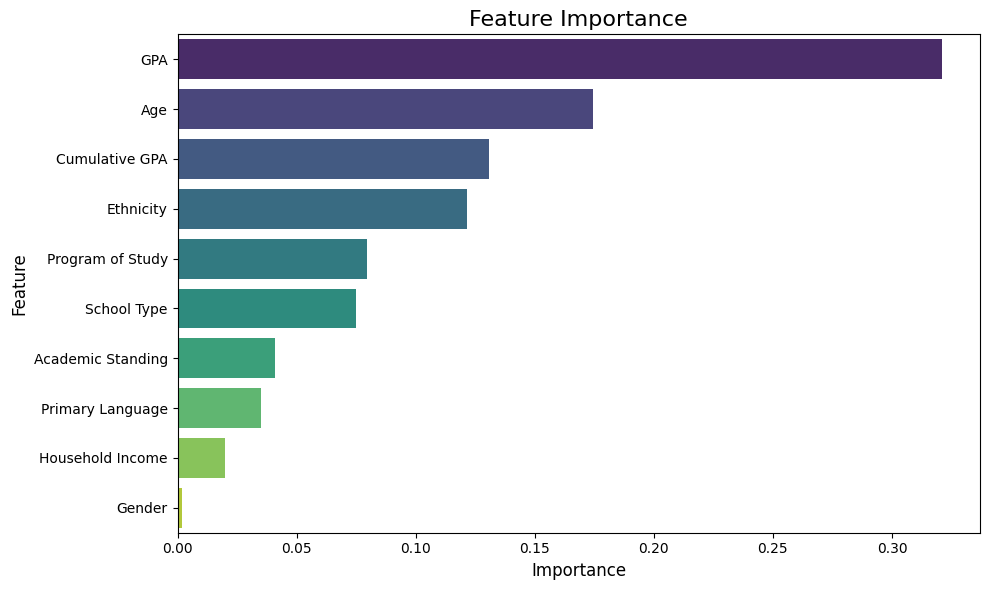

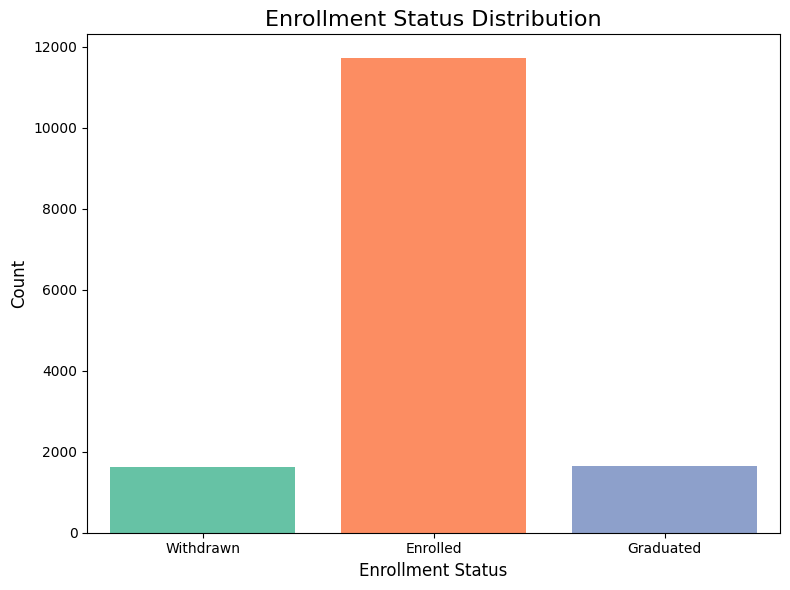

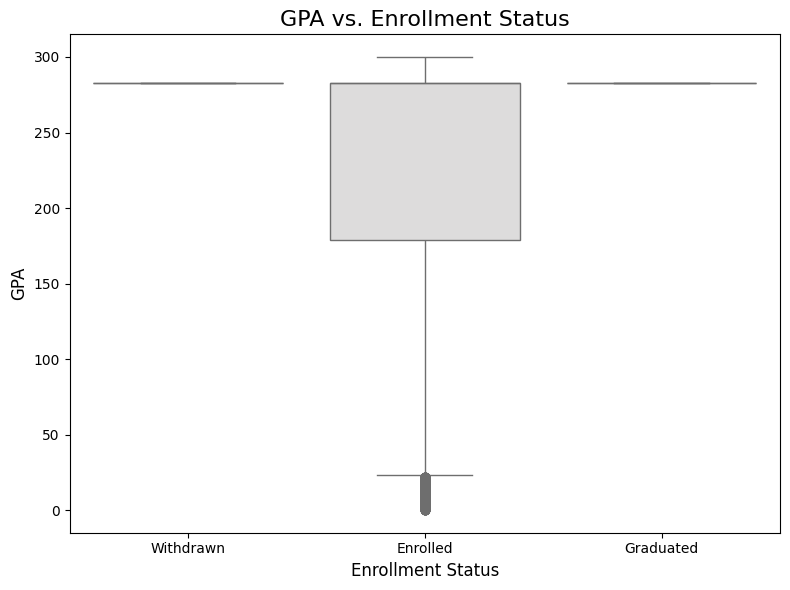

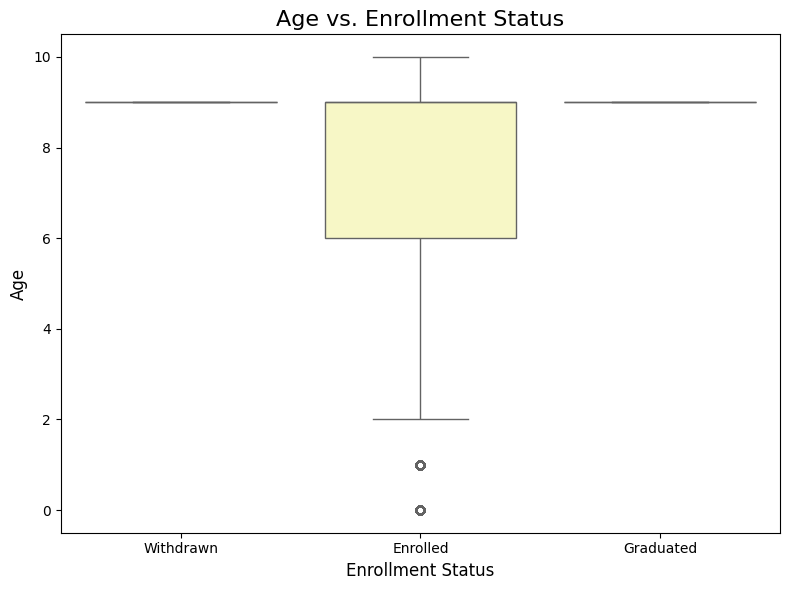

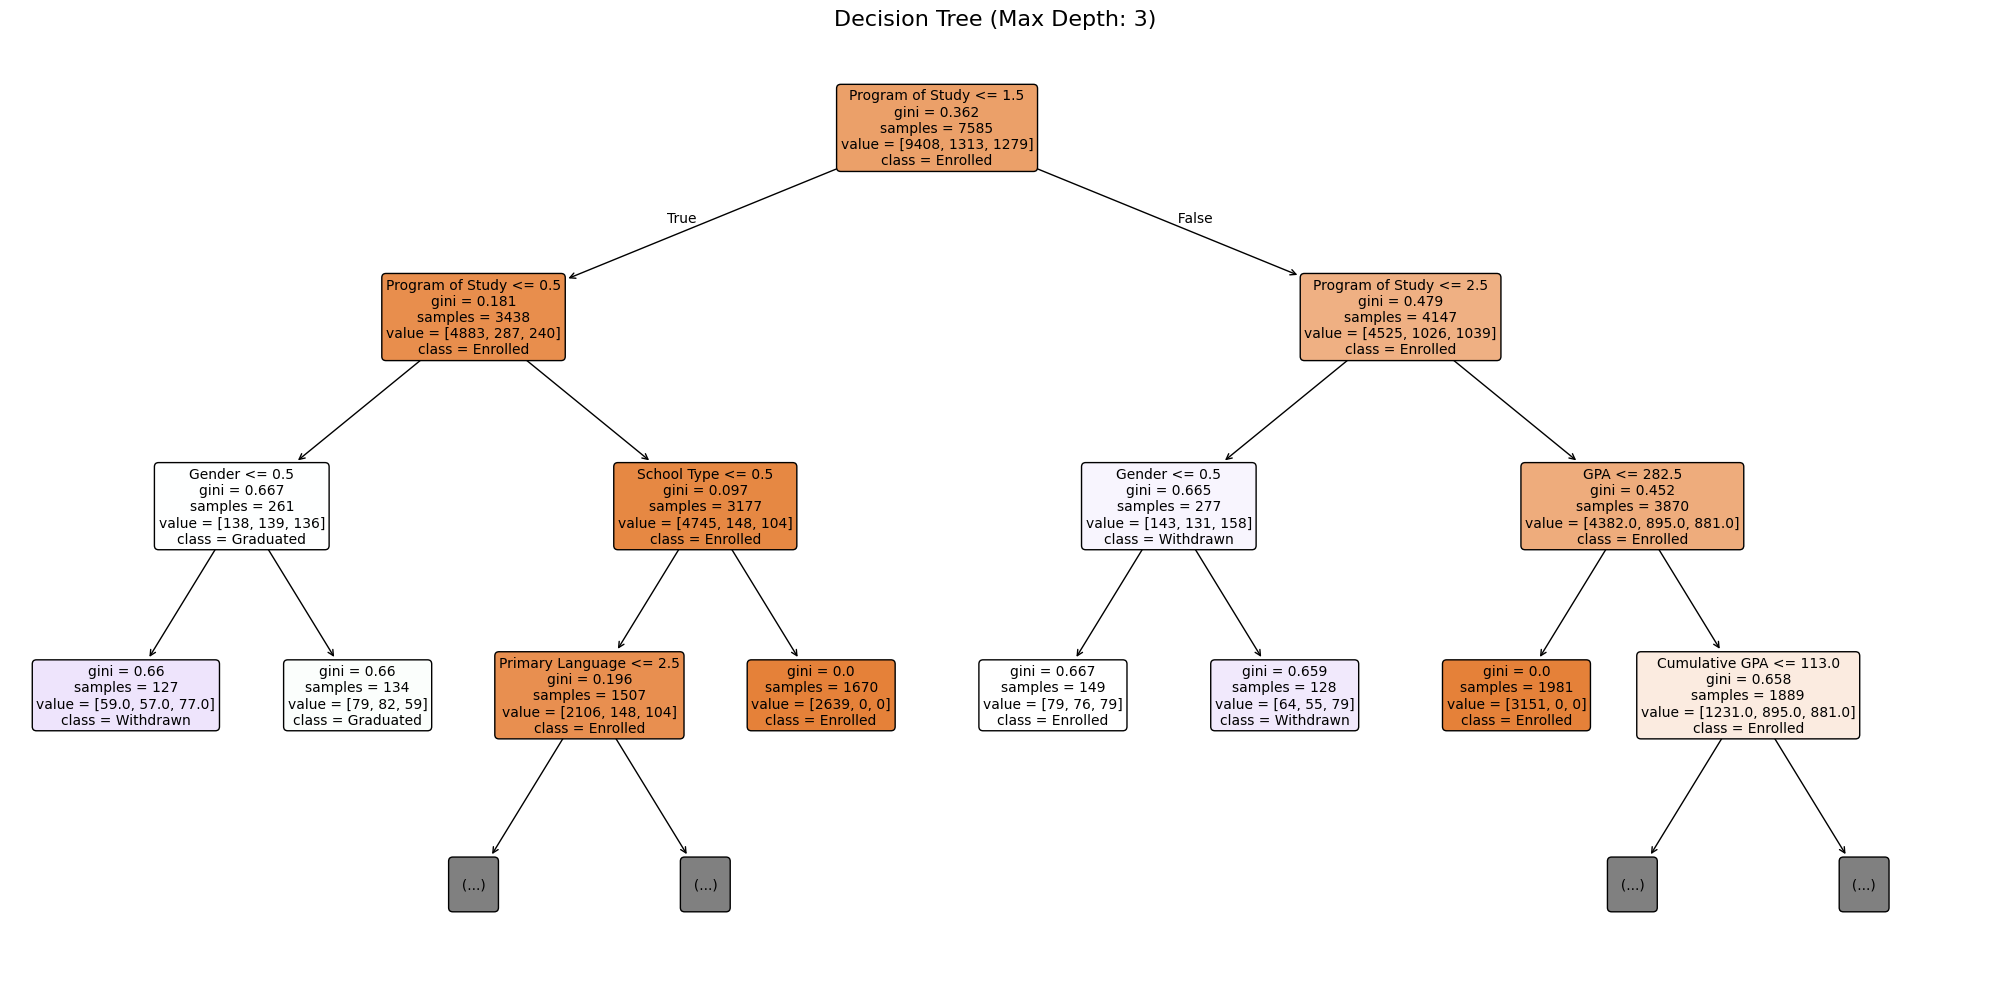

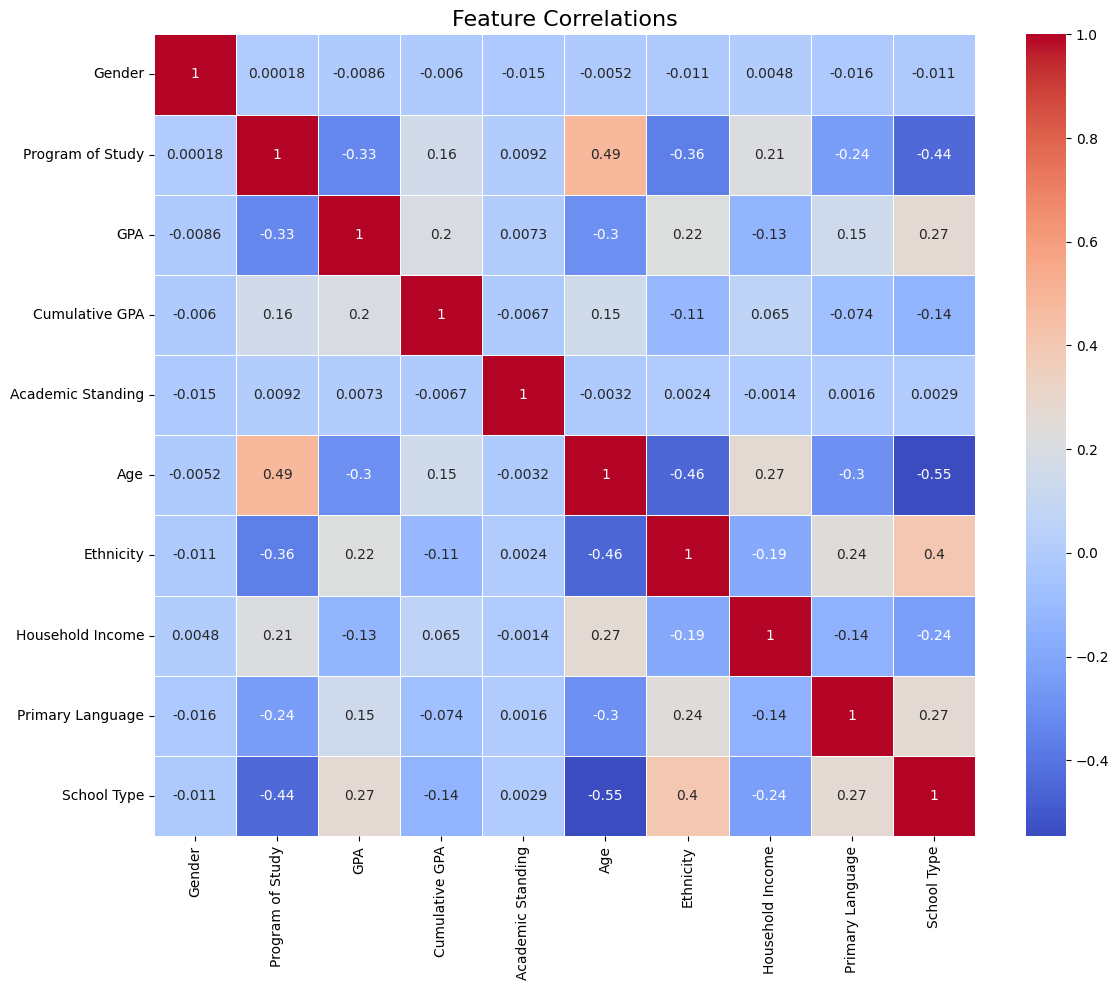

In [488]:
# Call the function to create all visualizations
create_visualizations(rf_model, X, y, features)